<a href="https://colab.research.google.com/github/ayush139/MMX/blob/main/MMX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("husl")
sns.set_style('darkgrid')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))
print(df)

     wk_strt_dt  yr_nbr  qtr_nbr  ...  seas_week_46  seas_week_47  seas_week_48
0    2014-08-03    2014        3  ...             0             0             0
1    2014-08-10    2014        3  ...             0             0             0
2    2014-08-17    2014        3  ...             0             0             0
3    2014-08-24    2014        3  ...             0             0             0
4    2014-08-31    2014        3  ...             0             0             0
..          ...     ...      ...  ...           ...           ...           ...
204  2018-07-01    2018        2  ...             0             0             0
205  2018-07-08    2018        2  ...             0             0             0
206  2018-07-15    2018        2  ...             0             0             0
207  2018-07-22    2018        2  ...             0             0             0
208  2018-07-29    2018        2  ...             0             0             0

[209 rows x 80 columns]


In [4]:
# 1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
st_cols = ['st_ct']
# markdown/discount variables
mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
base_vars = me_cols+st_cols+mrkdn_cols+hldy_cols+seas_cols

# 3. sales variables
sales_cols =['sales']

df[['wk_strt_dt']+mdip_cols+['sales']].head()

,wk_strt_dt,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,mdip_sms,mdip_aff,mdip_sem,sales
0,2014-08-03,4863885,29087520,2421933,692315,37778097,10038746,2111112,0,3271007,1514755,27281,197828,83054,72051457.64
1,2014-08-10,20887502,8345120,3984494,475810,12063657,9847977,587184,0,4260715,2234569,27531,123688,83124,78794770.54
2,2014-08-17,11097724,17276800,1846832,784732,5770115,7235336,1015658,0,4405992,1616990,55267,186781,79768,70071185.56
3,2014-08-24,1023446,18468480,2394834,1032301,12174000,8625122,2149160,0,6638320,1897998,32470,122389,138936,68642464.59
4,2014-08-31,21109811,26659920,3312008,400456,31656134,19785657,2408661,0,4347752,2569158,55878,209969,87531,86190784.65


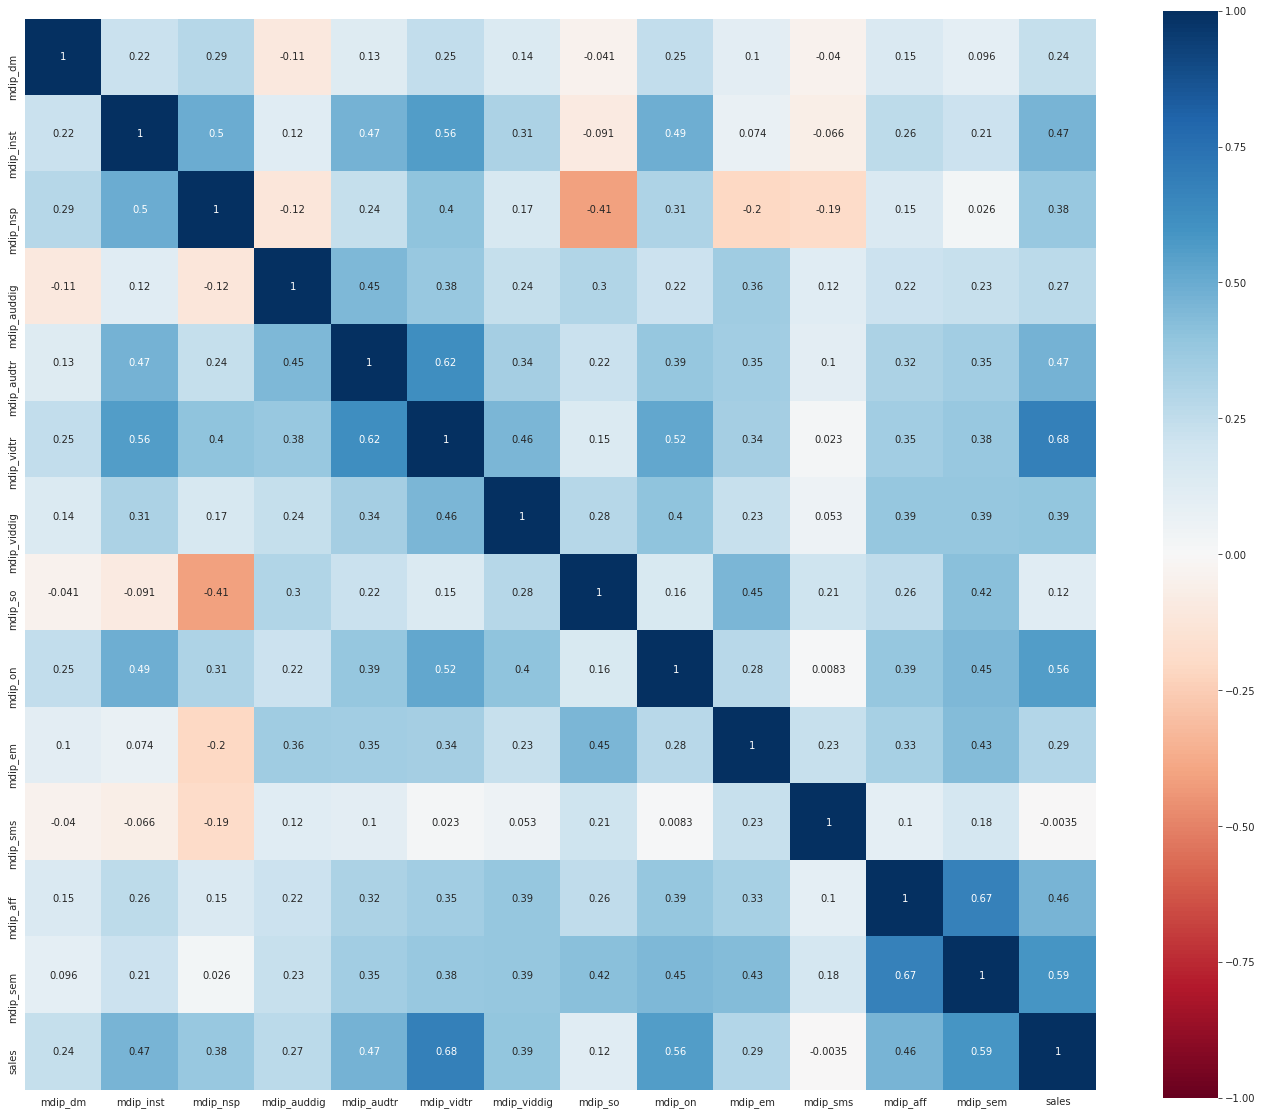

In [5]:
# EDA - correlation, distribution plots
plt.figure(figsize=(24,20))
sns.heatmap(df[mdip_cols+['sales']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

<Figure size 3600x3600 with 0 Axes>

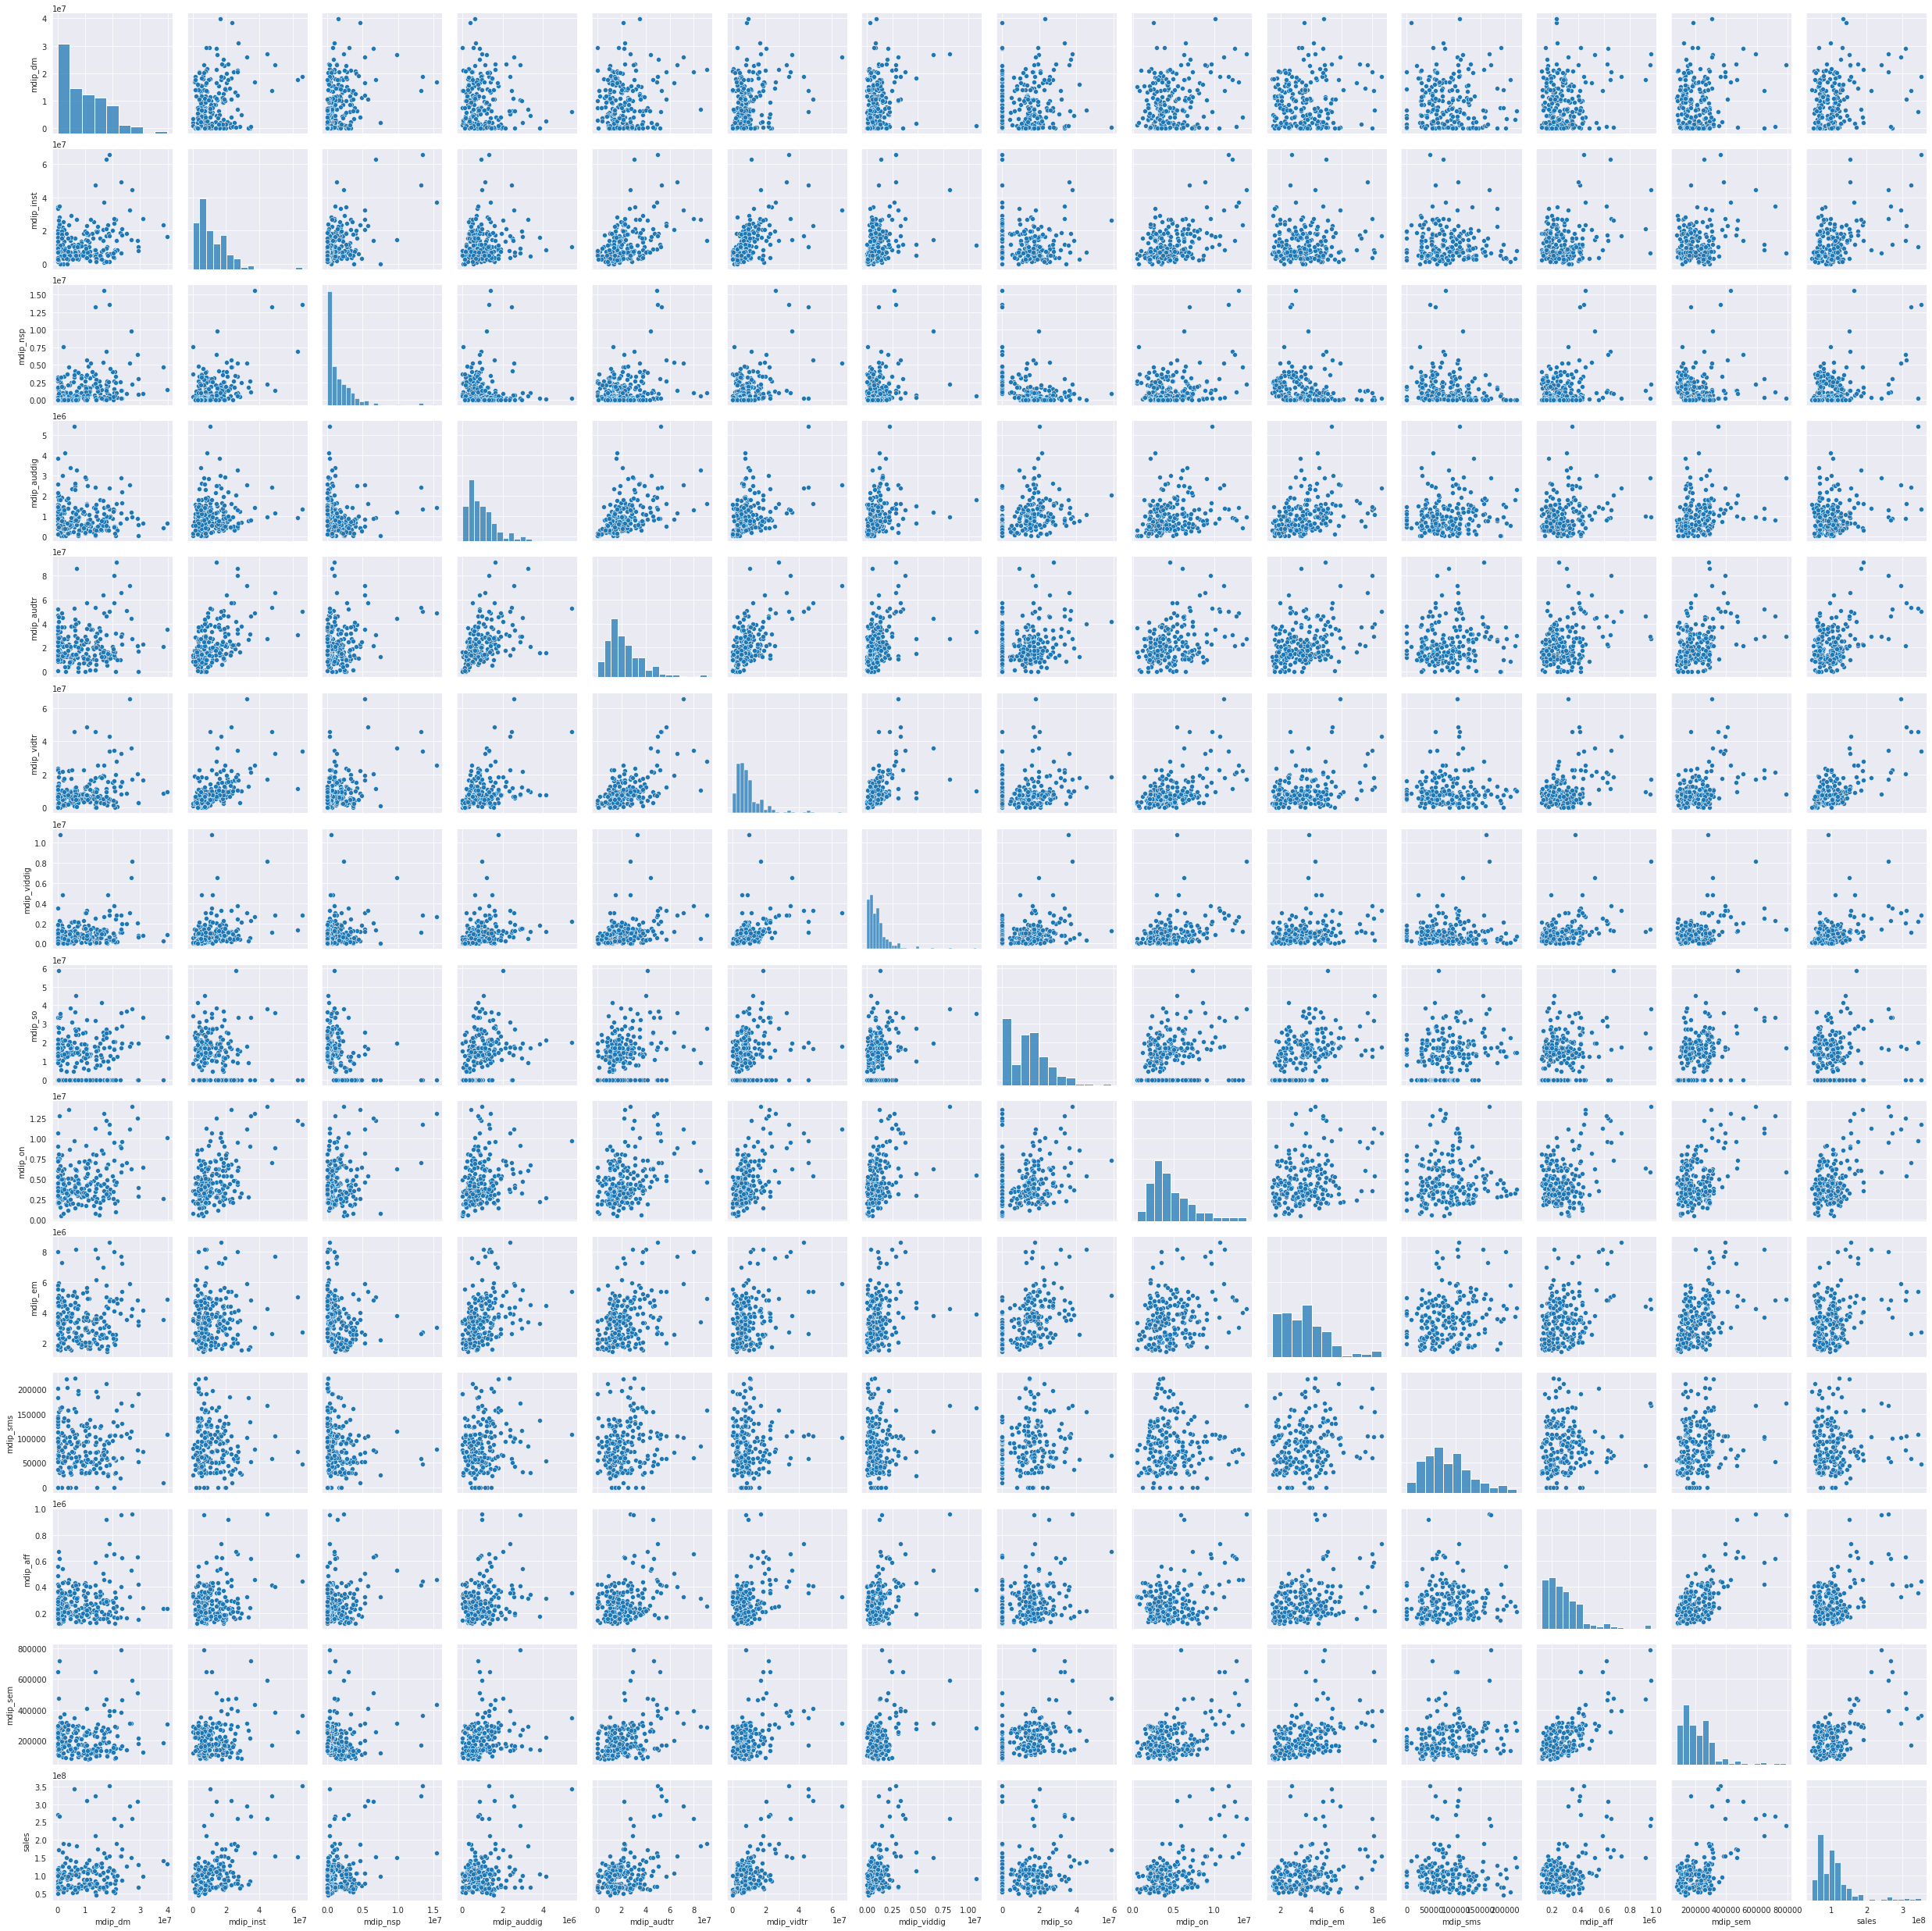

In [6]:
plt.figure(figsize=(50,50))
sns.pairplot(df[mdip_cols+['sales']], vars=mdip_cols+['sales'])

In [7]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

Text(0.5, 1.0, 'Adstock Parameter: Length')

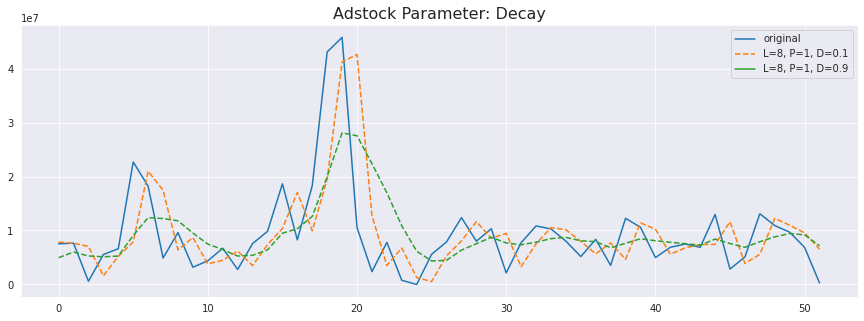

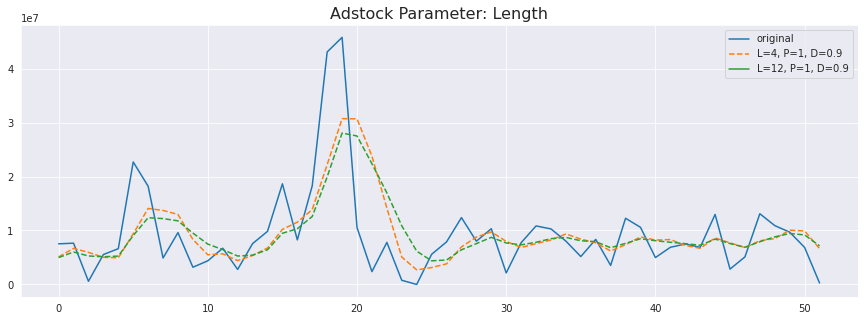

In [8]:
# plot adstock with varying decay
fig, ax = plt.subplots(figsize=(15,5))
psets = [
    [8, 1, 0.1],
    [8, 1, 0.9]
]
xm = df['mdip_vidtr'].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
    p = psets[i]
    L, P, D = p[0], p[1], p[2]
    xm_adstocked = apply_adstock(xm, L, P, D)
    sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
    ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Decay', fontsize=16)

# plot adstock with varying length
fig, ax = plt.subplots(figsize=(15,5))
psets = [
    [4, 1, 0.9],
    [12, 1, 0.9]
]
xm = df['mdip_vidtr'].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
    p = psets[i]
    L, P, D = p[0], p[1], p[2]
    xm_adstocked = apply_adstock(xm, L, P, D)
    sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
    ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Length', fontsize=16)


In [9]:
# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

Text(0.5, 1.0, 'Hill Function')

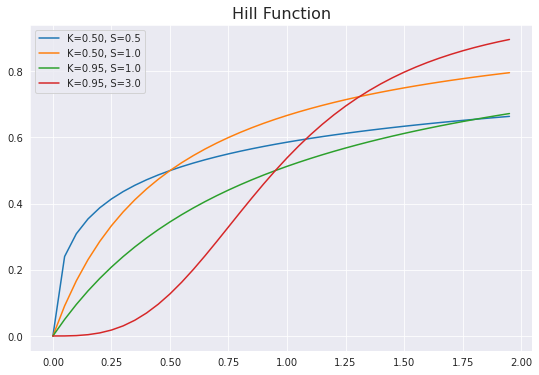

In [10]:
# plot hill function with varying K and S
fig, ax = plt.subplots(figsize=(9,6))
psets = [
    [0.5, 0.5],
    [0.5, 1.0],
    [0.95, 1.0],
    [0.95, 3.0]
]
xm = np.arange(0,2,0.05)
for i in range(len(psets)):
    p = psets[i]
    ec, slope = p[0], p[1]
    sns.lineplot(x=xm, y=hill_transform(xm, ec, slope), ax=ax, 
                  label='K=%.2f, S=%.1f'%(ec, slope))
    #ax.lines[i+1].set_linestyle("--")
ax.set_title('Hill Function', fontsize=16)

In [11]:
# 2.1 Control Model / Base Sales Model
import pystan
import os

In [12]:
# helper functions
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [13]:
# mean-centralize: sales, numeric base_vars
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_548939bc33801f8115bc26206558c913 NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0], Cython 0.29.22


Compiling /tmp/pystan_udy9iibp/stanfit4anon_model_548939bc33801f8115bc26206558c913_7844078726780110628.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_udy9iibp/stanfit4anon_model_548939bc33801f8115bc26206558c913_7844078726780110628.pyx
building 'stanfit4anon_model_548939bc33801f8115bc26206558c913_7844078726780110628' extension
creating /tmp/pystan_udy9iibp/tmp
creating /tmp/pystan_udy9iibp/tmp/pystan_udy9iibp
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_udy9iibp -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us

In [14]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

mape:  26.06662353758989


In [ ]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0], Cython 0.29.22


Compiling /tmp/pystan_634_g6wf/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8088058147603858251.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_634_g6wf/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8088058147603858251.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8088058147603858251' extension
creating /tmp/pystan_634_g6wf/tmp
creating /tmp/pystan_634_g6wf/tmp/pystan_634_g6wf
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_634_g6wf -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us